In [2]:
!pip install lifetimes --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from lifetimes import BetaGeoFitter, GammaGammaFitter


In [3]:
# Load the Online Retail Dataset
df = pd.read_excel("Online Retail.xlsx")
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
# Rename columns for consistency with CLV code
df.rename(columns={
    'Invoice': 'InvoiceNo',
    'Price': 'UnitPrice',
    'Customer ID': 'CustomerID'
}, inplace=True)

df.columns


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [5]:
# Remove missing data
df.dropna(inplace=True)

# Remove cancelled invoices
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Remove negative or zero values
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]


In [6]:
# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [7]:
# Convert date column
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Reference point = one day after last transaction
latest_date = df['InvoiceDate'].max() + timedelta(days=1)


In [8]:
# Group and aggregate
summary = df.groupby('CustomerID').agg({
    'InvoiceDate': [
        lambda x: (x.max() - x.min()).days,      # Recency
        lambda x: (latest_date - x.min()).days   # Customer age (T)
    ],
    'InvoiceNo': 'nunique',                     # Frequency
    'TotalPrice': 'sum'                         # Monetary value
}).reset_index()

# Rename columns
summary.columns = ['CustomerID', 'Recency', 'T', 'Frequency', 'Monetary']


In [9]:
# Remove one-time buyers
summary = summary[summary['Frequency'] > 1]

# Average order value
summary['Monetary'] = summary['Monetary'] / summary['Frequency']

# Convert days to weeks
summary['Recency'] = summary['Recency'] / 7
summary['T'] = summary['T'] / 7

summary.head()


,CustomerID,Recency,T,Frequency,Monetary
0,12346.0,28.000000,51.571429,11,33.896364
1,12347.0,5.285714,5.714286,2,661.660000
3,12349.0,25.857143,32.142857,3,890.380000
5,12352.0,2.285714,4.000000,2,171.900000
8,12356.0,6.285714,8.571429,3,1187.416667


In [10]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(summary['Frequency'], summary['Recency'], summary['T'])


<lifetimes.BetaGeoFitter: fitted with 2893 subjects, a: 0.14, alpha: 10.85, b: 2.72, r: 2.13>

In [11]:
# Predict expected purchases in 12 weeks
summary['PredictedPurchases_12Weeks'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    12, summary['Frequency'], summary['Recency'], summary['T']
)


In [12]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(summary['Frequency'], summary['Monetary'])

# Predict expected average profit per transaction
summary['ExpectedAvgProfit'] = ggf.conditional_expected_average_profit(
    summary['Frequency'], summary['Monetary']
)


In [13]:
summary['CLV_12Weeks'] = ggf.customer_lifetime_value(
    bgf, 
    summary['Frequency'], 
    summary['Recency'], 
    summary['T'], 
    summary['Monetary'], 
    time=12,  # weeks
    discount_rate=0.01
)


In [14]:
summary.to_csv("predicted_clv.csv", index=False)


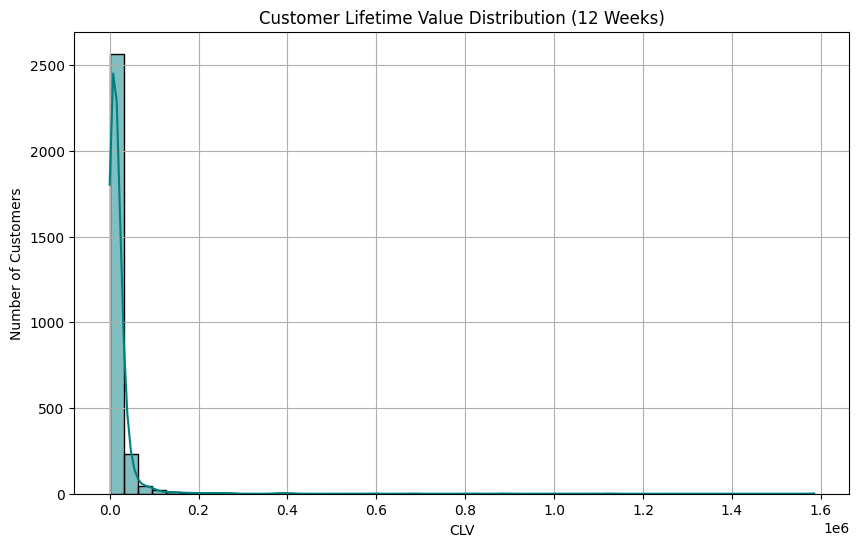

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(summary['CLV_12Weeks'], bins=50, kde=True, color='teal')
plt.title("Customer Lifetime Value Distribution (12 Weeks)")
plt.xlabel("CLV")
plt.ylabel("Number of Customers")
plt.grid(True)
plt.show()


In [16]:
summary.sort_values(by='CLV_12Weeks', ascending=False).head(10)


,CustomerID,Recency,T,Frequency,Monetary,PredictedPurchases_12Weeks,ExpectedAvgProfit,CLV_12Weeks
4183,18102.0,53.285714,53.428571,89,3923.194944,16.769688,3930.965384,1.585091e+06
1637,14646.0,51.714286,53.285714,78,3184.570513,14.615612,3191.778523,1.121473e+06
1269,14156.0,52.285714,53.428571,102,1927.124902,19.029486,1930.473129,8.833515e+05
3704,17450.0,10.000000,10.571429,7,7488.900000,4.841112,7681.447972,8.128085e+05
1840,14911.0,53.285714,53.428571,205,742.183268,38.147729,742.835483,6.814721e+05
939,13694.0,51.571429,53.000000,94,1398.331809,17.610509,1400.979333,5.929346e+05
9,12357.0,0.000000,3.428571,2,6039.995000,2.953515,6621.146066,4.119482e+05
3744,17511.0,52.714286,53.285714,31,2727.134516,6.086011,2742.736145,4.011385e+05
3177,16754.0,38.428571,39.571429,29,2258.623103,7.224996,2272.463146,3.868667e+05
3128,16684.0,50.285714,52.571429,27,2981.081852,5.364884,3000.666431,3.864814e+05
